In [1]:
import numpy as np
from scipy import stats
from numpy import nan
import pandas as pd
import s3fs
import getpass
import snowflake.connector
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.preprocessing import OneHotEncoder
import statistics
from matplotlib import pyplot as plt
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [3]:
conn = sf_connection()

### Let's read in the features we created

In [4]:
feature_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/score/yes_ecomm.parquet'

In [5]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

In [6]:
feature_table.dtypes

INDV_ID                                            object
fyGross                                           float64
2hGross                                           float64
4qGross                                           float64
fyNet                                             float64
2hNet                                             float64
4qNet                                             float64
numEcom                                             int64
numPurchase                                         int64
Recency                                             int32
daysSinceLastPurchase                               int32
isEmployee                                          int32
numReturn                                           int64
numCoupon                                           int64
LOYALTY_NUMBER                                      int64
meanPurchaseTransaction                           float64
FULLFILLMENT_STORE_NUMBER                           int32
pop_est_cy    

### Now we read in the label data

In [7]:
label_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv'

In [8]:
label_table = pd.read_csv(label_path, header=0)

In [9]:
label_table.dtypes

INDV_ID                int64
TX_COUNT               int64
DISCOUNT_FRACTION    float64
zero                   int64
quarter                int64
half                   int64
3quarter               int64
dtype: object

In [10]:
len(feature_table), len(label_table)

(22529095, 22327757)

In [11]:
len(feature_table.drop_duplicates('INDV_ID')), len(label_table.drop_duplicates('INDV_ID'))

(22529095, 22327757)

### Now we inner join on INDV_ID

In [12]:
combined_table = pd.merge(feature_table, label_table, on='INDV_ID', how='inner')

In [13]:
len(combined_table)

22325083

In [14]:
summary = pd.DataFrame(combined_table[['zero','quarter', 'half', '3quarter']].sum())

In [15]:
summary.rename(columns={0: 'count'}, inplace=True)

In [16]:
summary['total'] = len(combined_table)

In [17]:
summary['fraction'] = summary['count']/summary['total']

In [18]:
summary[['count', 'fraction']]

count             fraction
zero      5531576                0.248
quarter   4695237                0.210
half      3443785                0.154
3quarter  2945146                0.132

In [19]:
len(combined_table)

22325083

In [20]:
combined_table.drop_duplicates('INDV_ID', inplace=True)

In [21]:
len(combined_table)

22325083

In [22]:
combined_table.dtypes

INDV_ID                                            object
fyGross                                           float64
2hGross                                           float64
4qGross                                           float64
fyNet                                             float64
2hNet                                             float64
4qNet                                             float64
numEcom                                             int64
numPurchase                                         int64
Recency                                             int32
daysSinceLastPurchase                               int32
isEmployee                                          int32
numReturn                                           int64
numCoupon                                           int64
LOYALTY_NUMBER                                      int64
meanPurchaseTransaction                           float64
FULLFILLMENT_STORE_NUMBER                           int32
pop_est_cy    

In [23]:
combined_table.head()

INDV_ID              fyGross              2hGross              4qGross  \
0  112160037               12.990               12.990                0.000   
1  112161031               58.190               16.230                0.000   
2  112165122               26.780                0.000                0.000   
3  112166340              275.060               95.360                0.000   
4  112167529              189.450              177.460              153.480   

                 fyNet                2hNet                4qNet  numEcom  \
0               10.890               10.890                0.000        0   
1               31.380                6.730                0.000        0   
2               16.690                0.000                0.000        0   
3              153.620               59.610                0.000        0   
4              108.360              104.400               92.060        0   

   numPurchase  Recency  daysSinceLastPurchase  isEmployee  numReturn  \
0            1        0                    113           0          0   
1            4      196                    106           1          0   
2            1        0                    233           0          0   
3            5      177                     93           0          1   
4            4      263                     27           0          1   

   numCoupon    LOYALTY_NUMBER  meanPurchaseTransaction  \
0          0                -1                   12.990   
1          0  7770000033125471                   14.548   
2          0  7770000034438348                   26.780   
3          0                -1                   55.012   
4          0  7770131254155506                   47.363   

   FULLFILLMENT_STORE_NUMBER           pop_est_cy       pop_density_cy  \
0                       1212            9,055.540                0.003   
1                       2200            7,597.130                0.007   
2                       4590            9,302.290                0.006   
3                       5315           10,098.080                0.004   
4                       4550           14,449.920                0.005   

             pct_white                  age          pct_college  \
0                0.040               38.230                0.130   
1                0.180               36.040                0.120   
2                0.470               32.530                0.150   
3                0.040               36.450                0.140   
4                0.090               35.150                0.130   

       pct_blue_collar  median_household_income       establishments  \
0                0.180               48,610.969              244.690   
1                0.170               47,253.871              203.400   
2                0.200               45,750.109              299.100   
3                0.180               44,727.719              302.000   
4                0.170               43,973.070              254.690   

   IGNITIONEMISSIONFUELSYSTEMS  ADVANCECARESERVICES  AIRFILTERS  LIGHTING  \
0                            0                    0           0         0   
1                            0                    0           0         0   
2                            0                    0           0         0   
3                            0                    0           0         6   
4                            0                    0           0         0   

   HDHVAC&HYDRAULICS  COMMERCIALHANDSPECIALTYTOOLS  \
0                  0                             0   
1                  0                             0   
2                  0                             0   
3                  0                             0   
4                  0                             0   

   IGNITIONEMISSIONAIRINJECTION&O2SENSORS  WINTER&SUMMERSEASONAL  MOTOROIL  \
0                                       0                      0         0   
1                                       0 

## We now create two more features

In [24]:
combined_table['ecomm_frac'] = combined_table['numEcom']/combined_table['numPurchase']

In [25]:
combined_table['LOYALTY_NUMBER'].head()

0                  -1
1    7770000033125471
2    7770000034438348
3                  -1
4    7770131254155506
Name: LOYALTY_NUMBER, dtype: int64

In [26]:
combined_table['is_sp'] = combined_table['LOYALTY_NUMBER'].apply(lambda x: 1 if x > 0 else 0)

In [27]:
combined_table[['LOYALTY_NUMBER', 'is_sp']].head()

LOYALTY_NUMBER  is_sp
0                -1      0
1  7770000033125471      1
2  7770000034438348      1
3                -1      0
4  7770131254155506      1

In [28]:
combined_table.groupby('is_sp')['is_sp'].count()

is_sp
0    10895527
1    11429556
Name: is_sp, dtype: int64

In [29]:
combined_table['is_ecomm'] = combined_table['ecomm_frac'].apply(lambda x: 1 if x > 0.0 else 0)

In [30]:
summary = pd.DataFrame(combined_table[['zero','quarter', 'half', '3quarter']].sum())

In [31]:
summary.rename(columns={0: 'count'}, inplace=True)

In [32]:
summary['total'] = len(combined_table)

In [33]:
summary['fraction'] = summary['count']/summary['total']

In [34]:
summary[['count', 'fraction']]

count             fraction
zero      5531576                0.248
quarter   4695237                0.210
half      3443785                0.154
3quarter  2945146                0.132

In [35]:
combined_table.groupby(['is_sp', 'is_ecomm']).agg({'INDV_ID': 'count',
                                     'DISCOUNT_FRACTION': 'mean',
                                     'fyGross': 'mean', 
                                     'ecomm_frac': 'mean', 
                                     'meanPurchaseTransaction': 'mean',
                                     'numPurchase': 'mean',
                                     'maxVehicleAge': 'mean'})

INDV_ID    DISCOUNT_FRACTION              fyGross  \
is_sp is_ecomm                                                      
0     0         8993114                0.089               94.045   
      1         1902413                0.782              100.839   
1     0         9842403                0.079              164.790   
      1         1587153                0.539              341.617   

                         ecomm_frac  meanPurchaseTransaction  \
is_sp is_ecomm                                                 
0     0                       0.000                   60.348   
      1                       0.943                   68.536   
1     0                       0.000                   52.649   
      1                       0.588                   58.795   

                        numPurchase        maxVehicleAge  
is_sp is_ecomm                                            
0     0                       1.752                0.010  
      1                       1.573               11.794  
1     0                       3.423                0.006  
      1                       6.727               17.354

### Only keep customers with ecommerce engagement

In [36]:
combined_table = combined_table[combined_table.is_ecomm==1].copy()

In [37]:
len(combined_table)

3489566

In [38]:
summary = pd.DataFrame(combined_table[['zero','quarter', 'half', '3quarter']].sum())

In [39]:
summary.rename(columns={0: 'count'}, inplace=True)

In [40]:
summary['total'] = len(combined_table)

In [41]:
summary['fraction'] = summary['count']/summary['total']

In [42]:
summary[['count', 'fraction']]

count             fraction
zero      3099454                0.888
quarter   2767413                0.793
half      2147329                0.615
3quarter  1830582                0.525

### Now we join with dim_store to get the market type

In [43]:
store_query = """select STORE_NUMBER, MARKET_CLASS_CODE from PEDW.LOCATION.DIM_STORE_V"""

In [44]:
store_xref = pd.read_sql(store_query, conn)

In [45]:
len(store_xref)

7620

In [46]:
store_xref.head(100)

STORE_NUMBER MARKET_CLASS_CODE
0           1711                 6
1           6473                 6
2           8163                 3
3           3662                 5
4           4728                 4
5           2167                 4
6           7076                 4
7           5507           UNKNOWN
8           9372                 3
9           1912           UNKNOWN
10          9224                 6
11          1237                 5
12          7405                 6
13          5171                 6
14          9655                 6
15          2908           UNKNOWN
16          9794                 4
17          8700                 6
18          8274           UNKNOWN
19          5256                 4
20          7265                 4
21          9749                 4
22          5627           UNKNOWN
23          2942           UNKNOWN
24          8124                 6
25          8865                 4
26          4657                 6
27          2518           UNKNOWN
28          6104                 6
29          3408                 5
30          1102           UNKNOWN
31          6286                 4
32          5928           UNKNOWN
33          6731                 6
34          6109                 6
35          4287                 5
36          6315                 6
37          9714                 6
38          9669                 6
39          1998           UNKNOWN
40          5142                 6
41          6010                 6
42          6672                 4
43          3658                 5
44          3138                 4
45          3670                 6
46          6152                 4
47          3692                 5
48          6710                 4
49          2001                 6
50          7013           UNKNOWN
51          2708           UNKNOWN
52          3974                 6
53          6381                 6
54          3690                 6
55          9613                 4
56          7615                 5
57          2235                 6
58          3466                 6
59          3182                 7
60          5393                 6
61          5678                 5
62          5121                 5
63          6821                 6
64          6425                 6
65          2565           UNKNOWN
66          1314           UNKNOWN
67          7608                 3
68          4832           UNKNOWN
69          7775                 4
70          1869           UNKNOWN
71          4686                 6
72          4014                 5
73          6094                 7
74          4578                 4
75          6624                 7
76          3779                 4
77          2604           UNKNOWN
78          8349           UNKNOWN
79          5988                 5
80          6918                 5
81          5934                 7
82          4350                 6
83          4777                 6
84          7930                 5
85          5189                 4
86          4021                 6
87          4547                 6
88          3853                 6
89          1803                 5
90          5673                 4
91          9477                 6
92          3056                 5
93          5354           UNKNOWN
94          1929                 4
95          6919                 6
96          3883                 3
97          4319                 5
98          3850                 7
99          2603           UNKNOWN

In [47]:
store_xref = store_xref[store_xref.MARKET_CLASS_CODE != 'UNKNOWN'].copy()

In [48]:
len(store_xref)

6009

In [49]:
store_xref['MARKET_CLASS_CODE'] = store_xref['MARKET_CLASS_CODE'].apply(lambda x: int(x))

In [50]:
store_xref.dtypes

STORE_NUMBER         int64
MARKET_CLASS_CODE    int64
dtype: object

In [51]:
store_xref.rename(columns={'STORE_NUMBER': 'FULLFILLMENT_STORE_NUMBER'}, inplace=True)

### Now let's look at distances to AAP and competitor stores

In [52]:
aap_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V 
    where (INDV_ID, STORE_NUMBER, LOAD_TS) in (select INDV_ID, STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V
                                                group by INDV_ID, STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [53]:
aap_dist = pd.read_sql(aap_query, conn)

In [54]:
len(aap_dist)

119603044

In [55]:
aap_dist.head()

LOAD_TS    INDV_ID  STORE_NUMBER                 DIST  OPENED
0  20200820044008  180187438          6843                0.448       1
1  20200820044008  132645103          9378                0.249       1
2  20200820044008  235824487          7651                5.251       1
3  20200820044008  114777553          6514                9.609       1
4  20200820044008  135691948          8152                4.079       1

In [56]:
comp_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
    where (INDV_ID, CMP_STORE_NUMBER, LOAD_TS) in (select INDV_ID, CMP_STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
                                                group by INDV_ID, CMP_STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [57]:
comp_dist = pd.read_sql(comp_query, conn)

In [58]:
len(comp_dist)

120969758

In [59]:
comp_dist.head()

LOAD_TS    INDV_ID CMP_STORE_NUMBER                 DIST  OPENED
0  20200916155835  567791996            68019                0.916       1
1  20200916155835  127689638            43069                4.210       1
2  20200916155835  164812903            79256                1.653       1
3  20210215065830  613118320            77374                0.513       1
4  20200916155835  541048761            55255                0.295       1

In [60]:
aap_dist = aap_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'AAP_DIST'})

In [61]:
comp_dist = comp_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'CMP_DIST'})

In [62]:
len(aap_dist), len(aap_dist.drop_duplicates('INDV_ID'))

(119603044, 119603044)

In [63]:
len(comp_dist), len(comp_dist.drop_duplicates('INDV_ID'))

(120969758, 120969758)

### Now we join these dataframes to the combined table and fill nas

#### First the market code

In [64]:
combined_table = pd.merge(combined_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [65]:
combined_table.isnull().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


In [66]:
combined_table['MARKET_CLASS_CODE'].describe()

count          3,161,156.000
mean                   5.179
std                    1.173
min                    0.000
25%                    4.000
50%                    6.000
75%                    6.000
max                    7.000
Name: MARKET_CLASS_CODE, dtype: float64

#### Fill nulls with 0

In [67]:
combined_table.fillna(0, inplace=True)

#### Now aap store distances

In [68]:
combined_table = pd.merge(combined_table, aap_dist, how='left', on='INDV_ID')

In [69]:
combined_table.isna().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


In [70]:
combined_table['AAP_DIST'] = combined_table['AAP_DIST'].fillna(combined_table['AAP_DIST'].mean())

#### Now competitor store distances

In [71]:
combined_table = pd.merge(combined_table, comp_dist, how='left', on='INDV_ID')

In [72]:
combined_table.isna().sum()

INDV_ID                                        0
fyGross                                        0
2hGross                                        0
4qGross                                        0
fyNet                                          0
2hNet                                          0
4qNet                                          0
numEcom                                        0
numPurchase                                    0
Recency                                        0
daysSinceLastPurchase                          0
isEmployee                                     0
numReturn                                      0
numCoupon                                      0
LOYALTY_NUMBER                                 0
meanPurchaseTransaction                        0
FULLFILLMENT_STORE_NUMBER                      0
pop_est_cy                                     0
pop_density_cy                                 0
pct_white                                      0
age                 

In [73]:
combined_table['CMP_DIST'] = combined_table['CMP_DIST'].fillna(combined_table['CMP_DIST'].mean())

In [74]:
combined_table['aap_closer_by'] = combined_table['CMP_DIST'] - combined_table['AAP_DIST']

In [75]:
combined_table['comp_dist_ratio'] = combined_table['CMP_DIST']/combined_table['AAP_DIST']

### Now let's get the customer lifetime (age)

In [76]:
life_query = """
    select 
        INDV_ID, 
        datediff(day, INDV_FIRST_TRANSACTION_DATE, '2021-03-01') as LIFETIME
    from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
    where (INDV_ID,LOAD_TS) in
        (select INDV_ID, max(LOAD_TS) from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
        group by INDV_ID)
        """

In [77]:
life = pd.read_sql(life_query, conn, parse_dates=['ACQUIRED'])

In [78]:
life.dtypes

INDV_ID     int64
LIFETIME    int64
dtype: object

In [79]:
life.head()

INDV_ID  LIFETIME
0  542090562      2007
1  591557254      1079
2  297712381      2269
3  572581623      1488
4  591228963      1083

In [80]:
combined_table = pd.merge(combined_table, life, how='left', on='INDV_ID')

In [81]:
combined_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [82]:
combined_table['LIFETIME'].describe()

count          3,489,566.000
mean               1,335.203
std                1,022.753
min                  -46.000
25%                  283.000
50%                1,282.000
75%                2,392.000
max                2,806.000
Name: LIFETIME, dtype: float64

In [83]:
len(combined_table[combined_table.LIFETIME < 1])

3

In [84]:
combined_table.loc[(combined_table.LIFETIME < 1), 'LIFETIME'] = 1

In [85]:
combined_table['DISCOUNT_FRACTION'].describe()

count          3,489,566.000
mean                   0.672
std                    0.375
min                    0.000
25%                    0.333
50%                    0.857
75%                    1.000
max                    1.000
Name: DISCOUNT_FRACTION, dtype: float64

In [86]:
combined_table.groupby('MARKET_CLASS_CODE')['DISCOUNT_FRACTION'].mean()

MARKET_CLASS_CODE
0.000                  0.887
1.000                  0.661
2.000                  0.680
3.000                  0.676
4.000                  0.676
5.000                  0.661
6.000                  0.631
7.000                  0.605
Name: DISCOUNT_FRACTION, dtype: float64

In [87]:
combined_table['comp_dist_ratio'].describe()

count          3,489,566.000
mean                   0.942
std                    1.687
min                    0.000
25%                    0.511
50%                    0.775
75%                    1.008
max                  431.597
Name: comp_dist_ratio, dtype: float64

In [88]:
combined_table[combined_table.comp_dist_ratio > 1.5]['DISCOUNT_FRACTION'].mean()

0.615111760106694

In [89]:
combined_table[combined_table.comp_dist_ratio < 0.5]['DISCOUNT_FRACTION'].mean()

0.7260862570205467

In [90]:
combined_table[combined_table['LIGHTING'] > 0]['DISCOUNT_FRACTION'].mean()

0.3935755531746133

In [91]:
combined_table[combined_table['LIGHTING'] == 0]['DISCOUNT_FRACTION'].mean()

0.7115586124975954

In [92]:
combined_table[combined_table['MOTOROIL'] > 0]['DISCOUNT_FRACTION'].mean()

0.5043609702606575

In [93]:
combined_table[combined_table['MOTOROIL'] == 0]['DISCOUNT_FRACTION'].mean()

0.7173564288812845

In [94]:
combined_table[combined_table['fyGross'] > 200]['DISCOUNT_FRACTION'].mean()

0.5237975192047869

In [95]:
combined_table[combined_table['fyGross'] <= 200]['DISCOUNT_FRACTION'].mean()

0.735733654903083

In [96]:
combined_table.groupby('is_sp')['DISCOUNT_FRACTION'].mean()

is_sp
0                  0.782
1                  0.539
Name: DISCOUNT_FRACTION, dtype: float64

In [97]:
combined_table[combined_table['TX_COUNT'] > 7]['DISCOUNT_FRACTION'].mean()

0.43172308575637447

In [98]:
combined_table[combined_table['TX_COUNT'] <= 7]['DISCOUNT_FRACTION'].mean()

0.7149378977499871

In [99]:
combined_table[combined_table['meanPurchaseTransaction'] > 70]['DISCOUNT_FRACTION'].mean()

0.7556874888080598

In [100]:
combined_table[combined_table['meanPurchaseTransaction'] <= 70]['DISCOUNT_FRACTION'].mean()

0.6308104762854038

In [101]:
combined_table[combined_table['OpenRate'] > 0.5]['DISCOUNT_FRACTION'].mean()

0.6795914006092603

In [102]:
combined_table[combined_table['OpenRate'] <= 0.5]['DISCOUNT_FRACTION'].mean()

0.6709497599744163

In [103]:
combined_table['meanQuality'].mean()

26.294868

In [104]:
combined_table[combined_table['meanQuality'] > 26]['DISCOUNT_FRACTION'].mean()

0.7035351512686028

In [105]:
combined_table[combined_table['meanQuality'] <= 26]['DISCOUNT_FRACTION'].mean()

0.648170912362333

In [106]:
combined_table[combined_table['TRANSMISSIONFLUID'] > 0]['DISCOUNT_FRACTION'].mean()

0.43893327005972527

In [107]:
combined_table[combined_table['TRANSMISSIONFLUID'] <= 0]['DISCOUNT_FRACTION'].mean()

0.682771428661374

In [108]:
combined_table[combined_table['LIFETIME'] > 365]['DISCOUNT_FRACTION'].mean()

0.6220936612891725

In [109]:
combined_table[combined_table['LIFETIME'] <= 365]['DISCOUNT_FRACTION'].mean()

0.765417234303775

In [110]:
list(combined_table.columns)

['INDV_ID',
 'fyGross',
 '2hGross',
 '4qGross',
 'fyNet',
 '2hNet',
 '4qNet',
 'numEcom',
 'numPurchase',
 'Recency',
 'daysSinceLastPurchase',
 'isEmployee',
 'numReturn',
 'numCoupon',
 'LOYALTY_NUMBER',
 'meanPurchaseTransaction',
 'FULLFILLMENT_STORE_NUMBER',
 'pop_est_cy',
 'pop_density_cy',
 'pct_white',
 'age',
 'pct_college',
 'pct_blue_collar',
 'median_household_income',
 'establishments',
 'IGNITIONEMISSIONFUELSYSTEMS',
 'ADVANCECARESERVICES',
 'AIRFILTERS',
 'LIGHTING',
 'HDHVAC&HYDRAULICS',
 'COMMERCIALHANDSPECIALTYTOOLS',
 'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
 'WINTER&SUMMERSEASONAL',
 'MOTOROIL',
 'HORNSANDSECURITY',
 'COOLINGSYSTEMRADIATORS',
 'GREASE&GEAR',
 'OILFILTERS',
 'APPEARANCECHEMICALS',
 'HDFILTERS',
 'INTERIORACCESSORIES',
 'HDWHEELEND',
 'BRAKESHARDWARE',
 'OIL&GASACCESSORIES',
 'AIRTOOLS&ACCESSORIES',
 'PERFORMANCE&FUNCTIONALCHEMICALS',
 'STORESUPPLIES&FIXTURES',
 'BRAKESHYDRAULICS',
 'HDOTHER',
 'OTHERCORES',
 'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
 'RE

In [111]:
features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'TOTAL',
     'Sends',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'LIFETIME']

In [112]:
corr_series = combined_table[features].corrwith(combined_table.DISCOUNT_FRACTION)

In [113]:
corr_series.sort_values(ascending=True)

Recency                                                 -0.378
is_sp                                                   -0.324
numPurchase                                             -0.225
LIFETIME                                                -0.193
LIGHTING                                                -0.185
MARKET_CLASS_CODE                                       -0.185
PERFORMANCE&FUNCTIONALCHEMICALS                         -0.184
MOTOROIL                                                -0.158
TOTAL                                                   -0.157
fyGross                                                 -0.155
BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT                 -0.155
numReturn                                               -0.154
SEALANTSADHESIVESANDCOMPOUNDS                           -0.148
HAND&SPECIALTYTOOLS                                     -0.141
OILFILTERS                                              -0.137
OIL&GASACCESSORIES                                     

### Now we analyze market class

In [114]:
market_tup = (tuple(combined_table[['MARKET_CLASS_CODE', 'DISCOUNT_FRACTION']].groupby('MARKET_CLASS_CODE')))

In [115]:
market_list = [market_tup[i][1]['DISCOUNT_FRACTION'] for i in range(8)]

In [116]:
market_list = [market_tup[i+1][1]['DISCOUNT_FRACTION'] for i in range(7)]

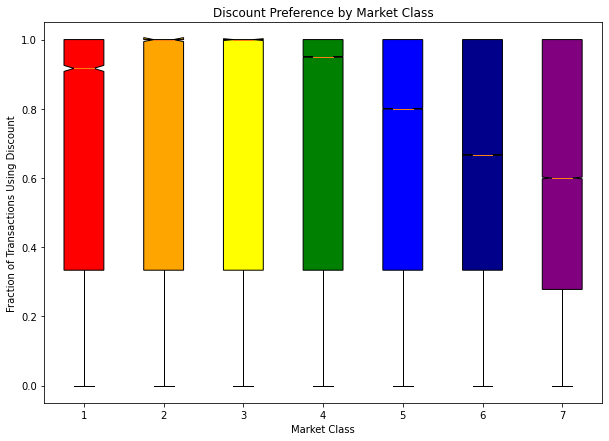

In [117]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))
ax1.set_title('Discount Preference by Market Class')
ax1.set_xlabel("Market Class")
ax1.set_ylabel("Fraction of Transactions Using Discount")
bplot = ax1.boxplot(market_list, notch=True, sym='', autorange=True, patch_artist=True)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'darkblue', 'purple']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [118]:
combined_table.groupby('MARKET_CLASS_CODE')['INDV_ID'].count()

MARKET_CLASS_CODE
0.000     338747
1.000      14168
2.000      33629
3.000     165113
4.000     711667
5.000     643956
6.000    1346974
7.000     235312
Name: INDV_ID, dtype: int64

### Now we analyze Speed Perks

In [119]:
sp_tup = (tuple(combined_table[['is_sp', 'DISCOUNT_FRACTION']].groupby('is_sp')))

In [120]:
sp_list = [sp_tup[i][1]['DISCOUNT_FRACTION'] for i in range(2)]

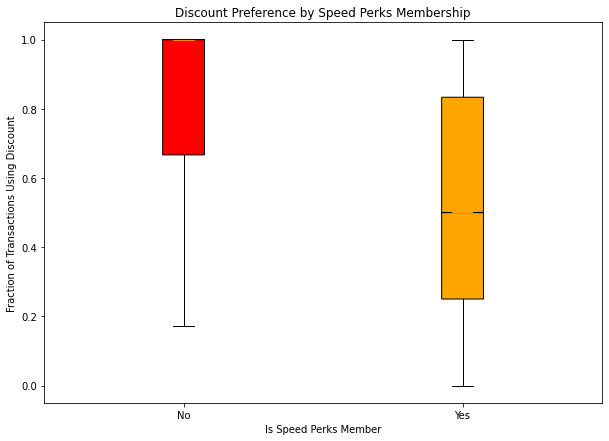

In [121]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))
ax1.set_title('Discount Preference by Speed Perks Membership')
ax1.set_xlabel("Is Speed Perks Member")
ax1.set_ylabel("Fraction of Transactions Using Discount")
labels = ['No', 'Yes']
bplot = ax1.boxplot(sp_list, notch=True, sym='', autorange=True, patch_artist=True, labels=labels)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'darkblue', 'purple']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [122]:
combined_table.groupby('is_sp')['INDV_ID'].count()

is_sp
0    1902413
1    1587153
Name: INDV_ID, dtype: int64

### Now we analyze frequency

In [123]:
freq_tup = (tuple(combined_table[['numPurchase', 'DISCOUNT_FRACTION']].groupby('numPurchase')))

In [124]:
freq_list = [freq_tup[i][1]['DISCOUNT_FRACTION'] for i in range(8)]

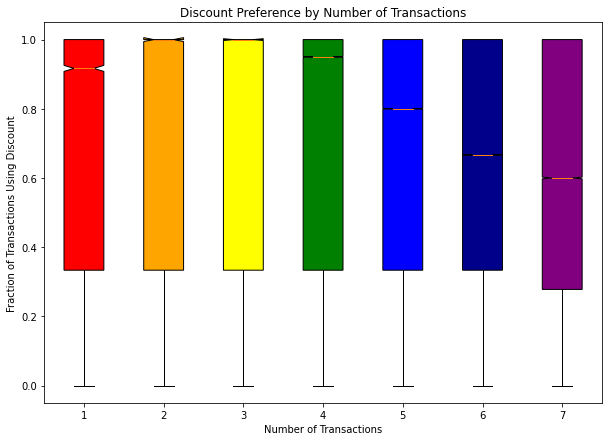

In [125]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))
ax1.set_title('Discount Preference by Number of Transactions')
ax1.set_xlabel("Number of Transactions")
ax1.set_ylabel("Fraction of Transactions Using Discount")
bplot = ax1.boxplot(market_list, notch=True, sym='', autorange=True, patch_artist=True)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'darkblue', 'purple']
for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [126]:
combined_table.groupby('numPurchase')['INDV_ID'].count()

numPurchase
1      1606485
2       555962
3       318578
4       213932
5       153356
6       115078
7        89144
8        69969
9        56502
10       45732
11       36917
12       30428
13       25203
14       21000
15       17854
16       15334
17       12963
18       10981
19        9530
20        8219
21        7235
22        6420
23        5433
24        4868
25        4295
26        3844
27        3365
28        2994
29        2737
30        2423
31        2156
32        1971
33        1762
34        1568
35        1496
36        1396
37        1238
38        1135
39        1004
40         923
41         874
42         775
43         795
44         702
45         653
46         599
47         583
48         553
49         488
50         466
51         400
52         414
53         380
54         359
55         347
56         322
57         318
58         306
59         281
60         261
61         253
62         248
63         247
64         265
65         200
66         22

### Now we do scatter plots

In [127]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

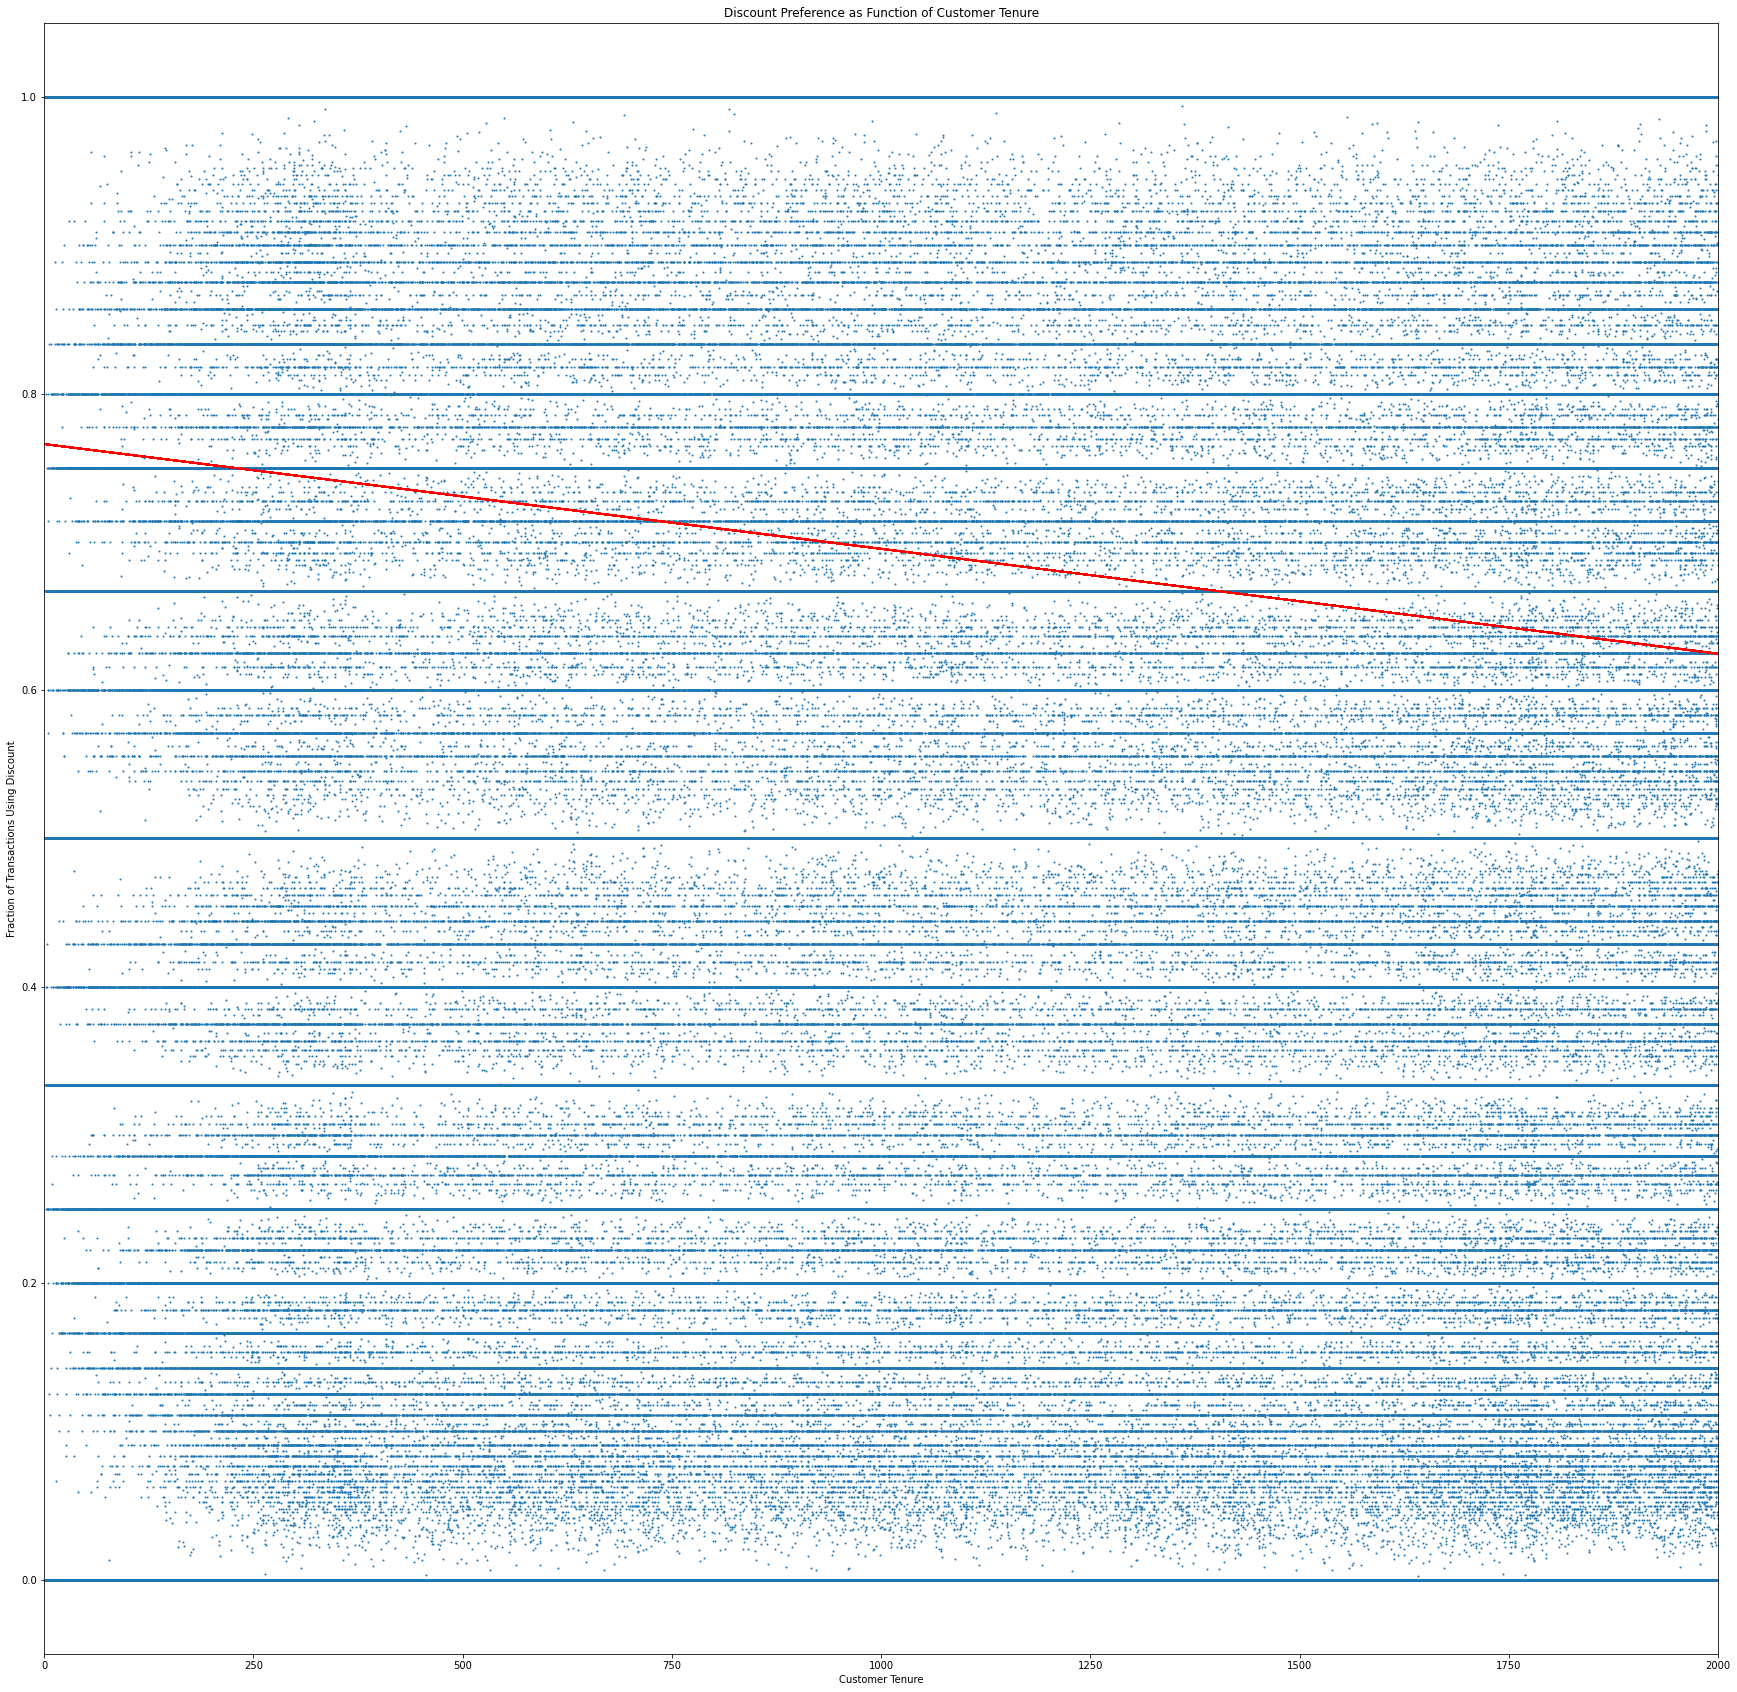

In [128]:
fig1, ax1 = plt.subplots(1, 1, figsize=(30, 30))
ax1.set_title('Discount Preference as Function of Customer Tenure')
ax1.set_xlabel("Customer Tenure")
ax1.set_ylabel("Fraction of Transactions Using Discount")
scat = ax1.scatter(combined_table['LIFETIME'], combined_table['DISCOUNT_FRACTION'], s=1)
plt.xlim([0, 2000])
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_table['LIFETIME'], combined_table['DISCOUNT_FRACTION'])
line = slope*combined_table['LIFETIME']+intercept
plt.plot(combined_table['LIFETIME'][::100], line[::100], 'r', label='fitted line')

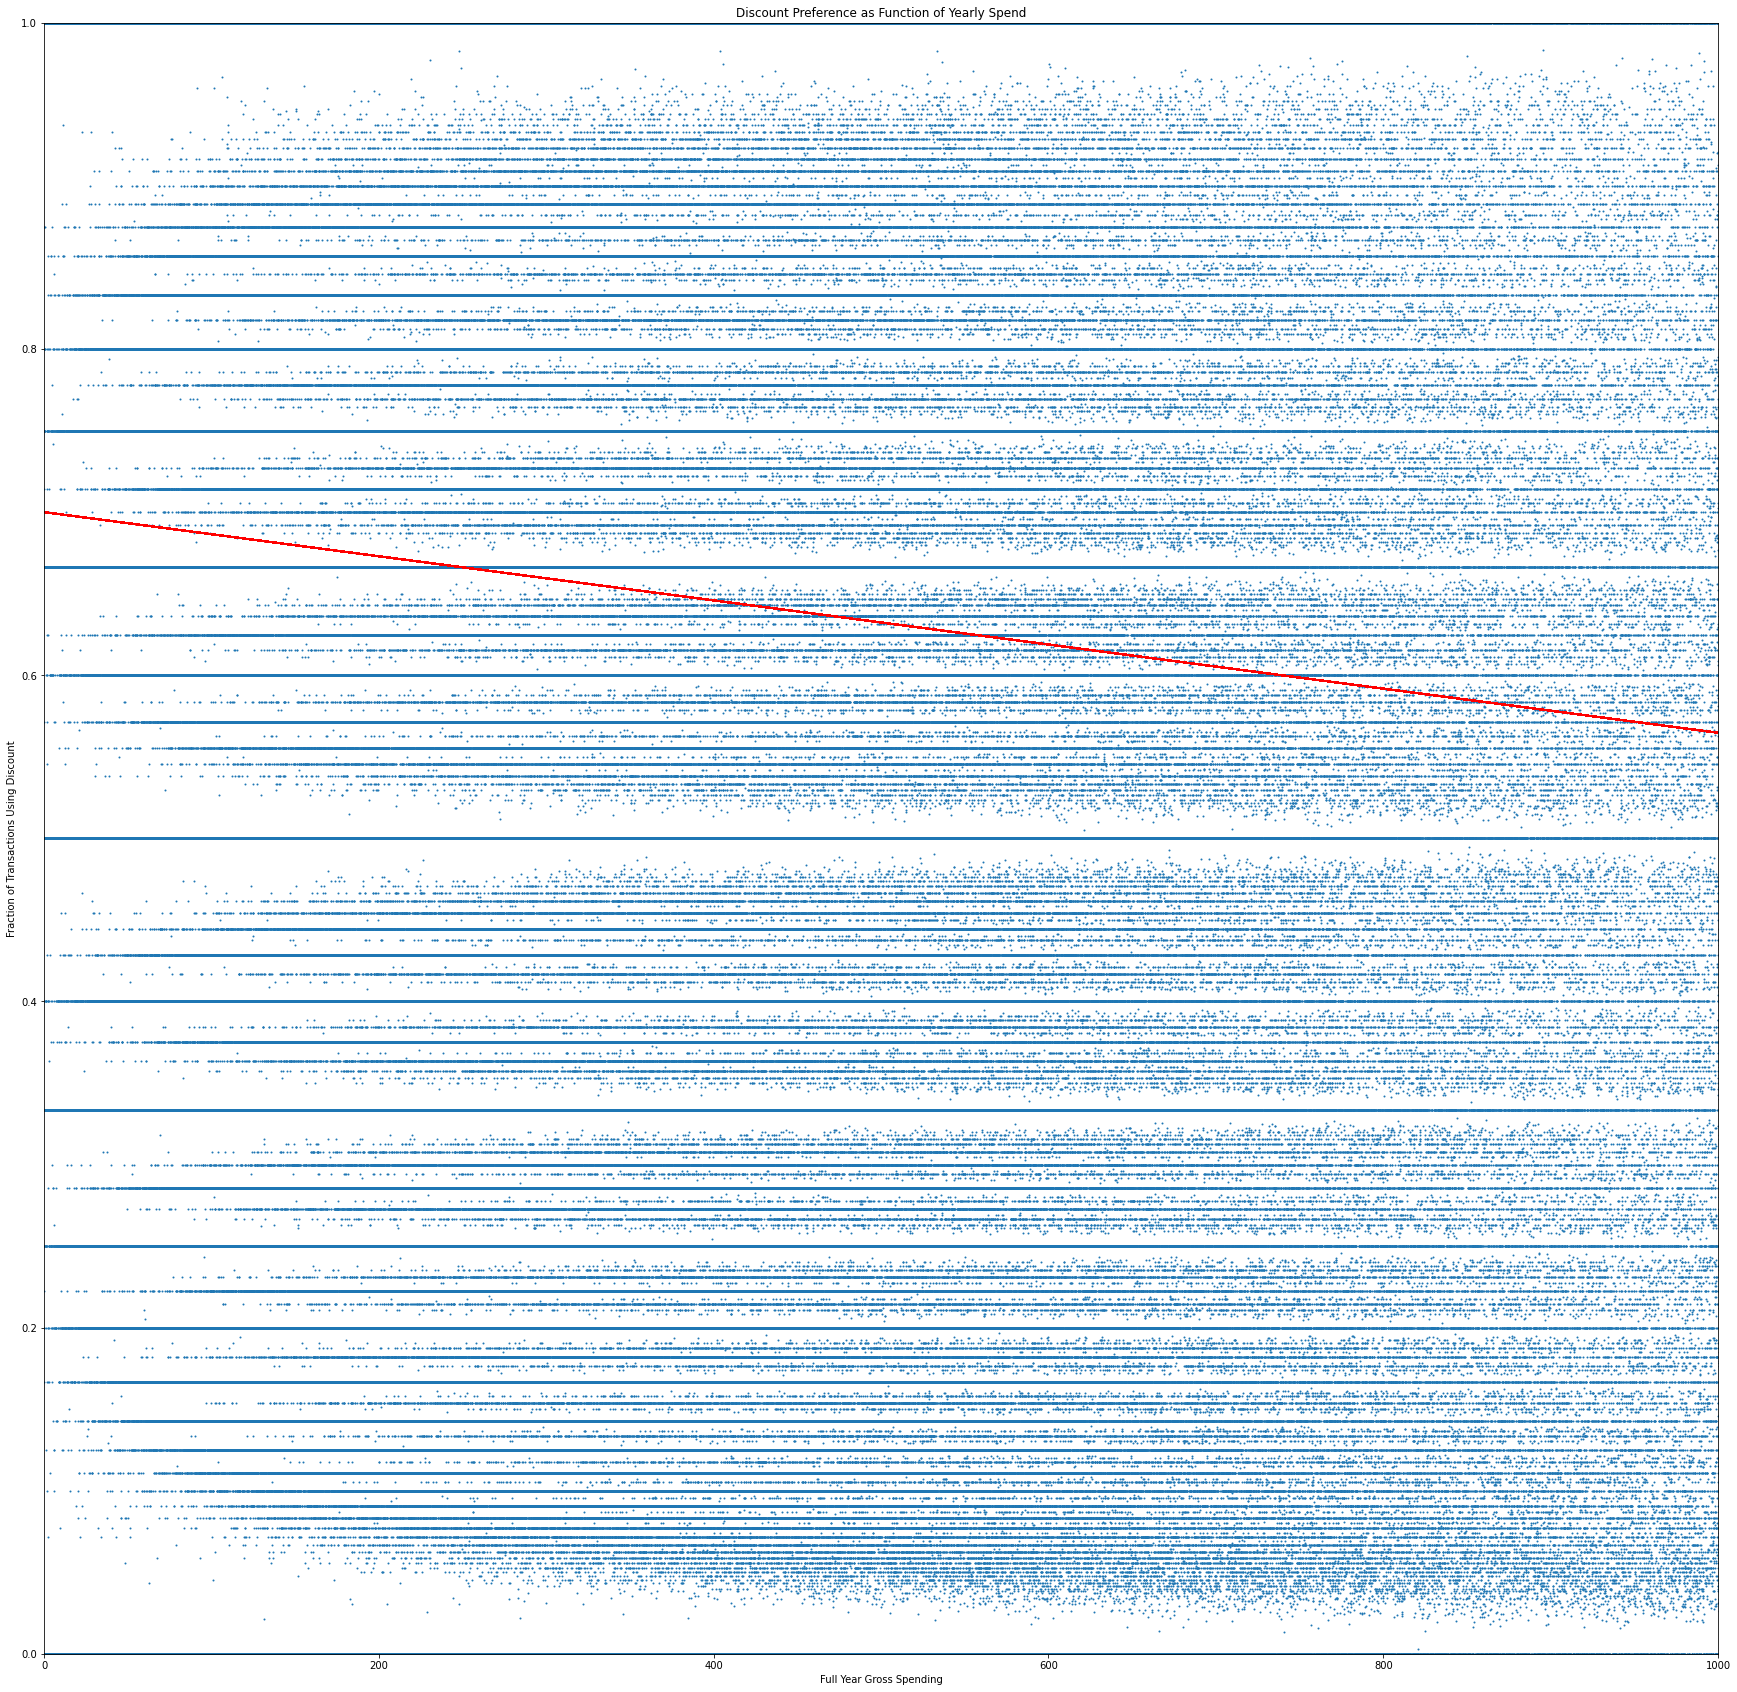

In [129]:
fig1, ax1 = plt.subplots(1, 1, figsize=(30, 30))
ax1.set_title('Discount Preference as Function of Yearly Spend')
ax1.set_xlabel("Full Year Gross Spending")
ax1.set_ylabel("Fraction of Transactions Using Discount")
scat = ax1.scatter(combined_table['fyGross'], combined_table['DISCOUNT_FRACTION'], s=1)
plt.xlim([0, 1000])
plt.ylim(0, 1)
slope, intercept, r_value, p_value, std_err = stats.linregress(combined_table['fyGross'], combined_table['DISCOUNT_FRACTION'])
line = slope*combined_table['fyGross']+intercept
plt.plot(combined_table['fyGross'][::100], line[::100], 'r', label='fitted line')